In [17]:
import pandas as pd
from scipy.stats import kendalltau
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import scatter_2d
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer


In [27]:
stock_data = pd.read_csv("data/NSE_20_Share_Historical_Data.csv")
currency_data = pd.read_csv("data/cbk_forex_raph.csv")

stock_data.head()
currency_data.head()

,Date,Currency,Mean,Buy,Sell
0,4/1/2024,KES / TSHS,15.9922,15.9207,16.0637
1,4/1/2024,SA RAND,8.3812,8.3591,8.4033
2,4/1/2024,EURO,172.2168,171.7535,172.6800
3,4/1/2024,CAN $,117.8343,117.5238,118.1448
4,4/1/2024,KES / RWF,8.0026,7.9237,8.0814


In [28]:
# Convert date columns to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m/%d/%Y')
currency_data['Date'] = pd.to_datetime(currency_data['Date'], format='%d/%m/%Y')


In [30]:
# Filter datasets to include only overlapping dates
common_dates = pd.merge(stock_data['Date'], currency_data['Date'], on='Date')['Date']
stock_data_filtered = stock_data[stock_data['Date'].isin(common_dates)]
currency_data_filtered = currency_data[currency_data['Date'].isin(common_dates)]

In [31]:
# Print lengths of filtered datasets
print("Length of stock_data_filtered:", len(stock_data_filtered))
print("Length of currency_data_filtered:", len(currency_data_filtered))

Length of stock_data_filtered: 1461
Length of currency_data_filtered: 30701


In [32]:
# Print unique dates in both datasets
print("Unique dates in stock_data_filtered:", stock_data_filtered['Date'].unique())
print("Unique dates in currency_data_filtered:", currency_data_filtered['Date'].unique())

Unique dates in stock_data_filtered: <DatetimeArray>
['2023-12-29 00:00:00', '2023-12-28 00:00:00', '2023-12-27 00:00:00',
 '2023-12-22 00:00:00', '2023-12-21 00:00:00', '2023-12-20 00:00:00',
 '2023-12-19 00:00:00', '2023-12-18 00:00:00', '2023-12-15 00:00:00',
 '2023-12-14 00:00:00',
 ...
 '2018-01-15 00:00:00', '2018-01-12 00:00:00', '2018-01-11 00:00:00',
 '2018-01-10 00:00:00', '2018-01-09 00:00:00', '2018-01-08 00:00:00',
 '2018-01-05 00:00:00', '2018-01-04 00:00:00', '2018-01-03 00:00:00',
 '2018-01-02 00:00:00']
Length: 1461, dtype: datetime64[ns]
Unique dates in currency_data_filtered: <DatetimeArray>
['2023-12-29 00:00:00', '2023-12-28 00:00:00', '2023-12-27 00:00:00',
 '2023-12-22 00:00:00', '2023-12-21 00:00:00', '2023-12-20 00:00:00',
 '2023-12-19 00:00:00', '2023-12-18 00:00:00', '2023-12-15 00:00:00',
 '2023-12-14 00:00:00',
 ...
 '2018-01-15 00:00:00', '2018-01-12 00:00:00', '2018-01-11 00:00:00',
 '2018-01-10 00:00:00', '2018-01-09 00:00:00', '2018-01-08 00:00:00',
 '2

In [42]:
stock_data_filtered.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-12-29,74773.85,"74,480.29","74,838.76","74,366.97",368.60M,0.36%
1,2023-12-28,74502.58,"73,768.64","74,502.58","73,734.59",384.58M,0.99%
2,2023-12-27,73768.64,"74,034.23","74,249.15","73,762.07",432.91M,-0.34%
3,2023-12-22,74023.27,"74,288.88","74,430.47","74,018.72",423.20M,-0.36%
4,2023-12-21,74289.02,"73,397.71","74,292.76","73,397.71",760.93M,1.21%


In [43]:
# Data Cleaning
# Replace non-numeric values with NaN
stock_data_filtered.replace({'Price': {'368.60M': pd.NA}}, inplace=True)

numeric_columns = [ 'Open', 'High', 'Low']

for col in numeric_columns:
    stock_data_filtered[col] = stock_data_filtered[col].str.replace(",", "").astype(float)

stock_data_filtered.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-12-29,74773.85,74480.29,74838.76,74366.97,368.60M,0.36%
1,2023-12-28,74502.58,73768.64,74502.58,73734.59,384.58M,0.99%
2,2023-12-27,73768.64,74034.23,74249.15,73762.07,432.91M,-0.34%
3,2023-12-22,74023.27,74288.88,74430.47,74018.72,423.20M,-0.36%
4,2023-12-21,74289.02,73397.71,74292.76,73397.71,760.93M,1.21%


In [44]:
# Preprocess 'Vol.' column
def preprocess_volume(volume):
    if isinstance(volume, str):
        if volume.endswith('M'):
            return float(volume[:-1]) * 1e6  # Multiply by 1 million
        elif volume.endswith('B'):
            return float(volume[:-1]) * 1e9  # Multiply by 1 billion
        else:
            return float(volume)
    else:
        return volume

stock_data_filtered['Vol.'] = stock_data_filtered['Vol.'].apply(preprocess_volume)

In [45]:
stock_data_filtered.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-12-29,74773.85,74480.29,74838.76,74366.97,368600000.0,0.36%
1,2023-12-28,74502.58,73768.64,74502.58,73734.59,384580000.0,0.99%
2,2023-12-27,73768.64,74034.23,74249.15,73762.07,432910000.0,-0.34%
3,2023-12-22,74023.27,74288.88,74430.47,74018.72,423200000.0,-0.36%
4,2023-12-21,74289.02,73397.71,74292.76,73397.71,760930000.0,1.21%


In [38]:
# Convert 'Price' column to numeric, converting non-numeric values to NaN
stock_data_filtered['Price'] = pd.to_numeric(stock_data_filtered['Price'], errors='coerce')

stock_data_filtered.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-12-29,74773.85,"74,480.29","74,838.76","74,366.97",368.60M,0.36%
1,2023-12-28,74502.58,"73,768.64","74,502.58","73,734.59",384.58M,0.99%
2,2023-12-27,73768.64,"74,034.23","74,249.15","73,762.07",432.91M,-0.34%
3,2023-12-22,74023.27,"74,288.88","74,430.47","74,018.72",423.20M,-0.36%
4,2023-12-21,74289.02,"73,397.71","74,292.76","73,397.71",760.93M,1.21%


In [46]:
stock_data_filtered['Change %'] = stock_data_filtered['Change %'].str.replace("%", '').astype(float)

In [47]:
stock_data_filtered.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-12-29,74773.85,74480.29,74838.76,74366.97,368600000.0,0.36
1,2023-12-28,74502.58,73768.64,74502.58,73734.59,384580000.0,0.99
2,2023-12-27,73768.64,74034.23,74249.15,73762.07,432910000.0,-0.34
3,2023-12-22,74023.27,74288.88,74430.47,74018.72,423200000.0,-0.36
4,2023-12-21,74289.02,73397.71,74292.76,73397.71,760930000.0,1.21


In [48]:
# Drop rows with NaN values
stock_data_filtered.dropna(subset=['Price'], inplace=True)

stock_data_filtered.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-12-29,74773.85,74480.29,74838.76,74366.97,368600000.0,0.36
1,2023-12-28,74502.58,73768.64,74502.58,73734.59,384580000.0,0.99
2,2023-12-27,73768.64,74034.23,74249.15,73762.07,432910000.0,-0.34
3,2023-12-22,74023.27,74288.88,74430.47,74018.72,423200000.0,-0.36
4,2023-12-21,74289.02,73397.71,74292.76,73397.71,760930000.0,1.21


In [50]:
# Impute missing values (excluding datetime column)
imputer = KNNImputer()
stock_data_filtered_imputed = pd.DataFrame(imputer.fit_transform(stock_data_filtered.drop(columns=['Date'])))

stock_data_filtered_imputed.head()

,0,1,2,3,4,5
0,74773.85,74480.29,74838.76,74366.97,368600000.0,0.36
1,74502.58,73768.64,74502.58,73734.59,384580000.0,0.99
2,73768.64,74034.23,74249.15,73762.07,432910000.0,-0.34
3,74023.27,74288.88,74430.47,74018.72,423200000.0,-0.36
4,74289.02,73397.71,74292.76,73397.71,760930000.0,1.21


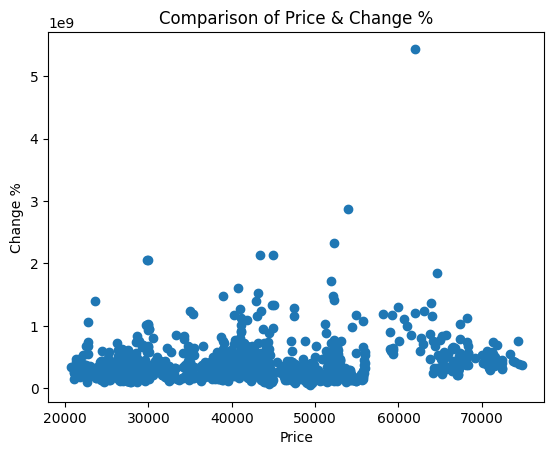

In [61]:
plt.scatter(stock_data_filtered_imputed[0], stock_data_filtered_imputed[4])
plt.xlabel('Price')
plt.ylabel('Change %')
plt.title("Comparison of Price & Change %")
plt.show()

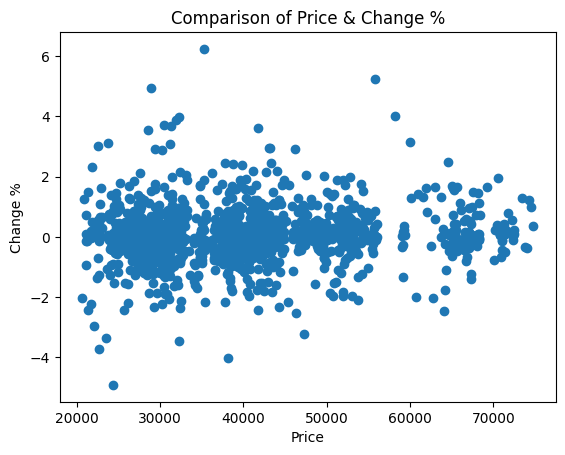

In [62]:
plt.scatter(stock_data_filtered_imputed[0], stock_data_filtered_imputed[5])
plt.xlabel('Price')
plt.ylabel('Change %')
plt.title("Comparison of Price & Change %")
plt.show()

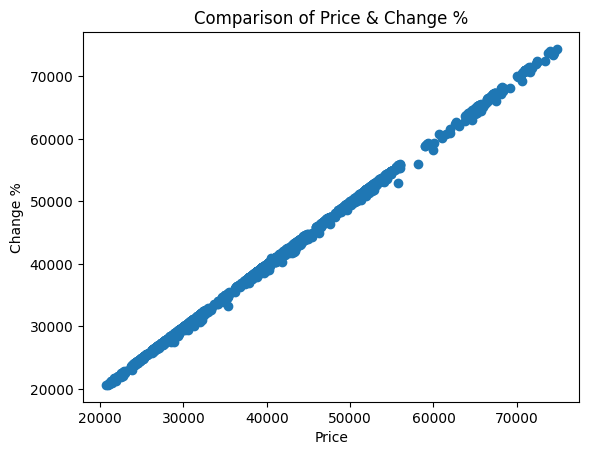

In [63]:
plt.scatter(stock_data_filtered_imputed[0], stock_data_filtered_imputed[3])
plt.xlabel('Price')
plt.ylabel('Change %')
plt.title("Comparison of Price & Change %")
plt.show()

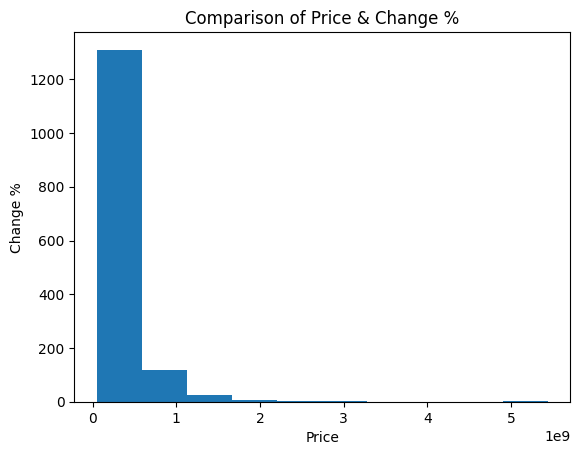

In [65]:
plt.hist(stock_data_filtered_imputed[4])
plt.xlabel('Price')
plt.ylabel('Change %')
plt.title("Comparison of Price & Change %")
plt.show()

In [52]:
# Copula Model Fitting
copula = GaussianMultivariate()
copula.fit(stock_data_filtered_imputed[[0, 1]])

# Dependence Measure (alternative)
correlation = stock_data_filtered_imputed[0].corr(stock_data_filtered_imputed[1])
kendall_tau, _ = kendalltau(stock_data_filtered_imputed[0], stock_data_filtered_imputed[1])

C:\tools\Manim\Lib\site-packages\scipy\stats\_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
C:\tools\Manim\Lib\site-packages\scipy\stats\_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)


In [53]:
correlation

0.9995982508166867

In [54]:
kendall_tau

0.9796718790655794